# COVID by county

Similar idea: https://sgallup.shinyapps.io/covidshiny/
Data from: https://github.com/nytimes/covid-19-data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#%load_ext nb_black

Next iteration:
- get county size and get per capita

# Import data from NYTimes



In [2]:
os.chdir(
    "/Users/lacar/Documents/Data_science/Jupyter_notebooks/covid_2020/covid-19-data/"
)

In [3]:
!git pull

remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Total 710 (delta 106), reused 106 (delta 106), pack-reused 604
Receiving objects: 100% (710/710), 5.52 MiB | 1.87 MiB/s, done.
Resolving deltas: 100% (405/405), completed with 16 local objects.
From https://github.com/nytimes/covid-19-data
   978e813..77d0cbe  master     -> origin/master
Updating 978e813..77d0cbe
Fast-forward
 README.md                |    18 +
 excess-deaths/README.md  |   132 +-
 excess-deaths/deaths.csv |  9147 ++++++----
 live/us-counties.csv     |  6228 +++----
 live/us-states.csv       |   110 +-
 live/us.csv              |     2 +-
 us-counties.csv          | 41328 ++++++++++++++++++++++++++++++++++++++++++++-
 us-states.csv            |   883 +-
 us.csv                   |   157 +-
 9 files changed, 50222 insertions(+), 7783 deletions(-)


In [4]:
os.chdir("/Users/lacar/Documents/Data_science/Jupyter_notebooks/covid_2020/")

In [5]:
df_covid = pd.read_csv("covid-19-data/us-counties.csv")
df_covid["county_state"] = df_covid["county"] + " County, " + df_covid["state"]

In [6]:
df_covid.head()

,date,county,state,fips,cases,deaths,county_state
0,2020-01-21,Snohomish,Washington,53061.0,1,0,"Snohomish County, Washington"
1,2020-01-22,Snohomish,Washington,53061.0,1,0,"Snohomish County, Washington"
2,2020-01-23,Snohomish,Washington,53061.0,1,0,"Snohomish County, Washington"
3,2020-01-24,Cook,Illinois,17031.0,1,0,"Cook County, Illinois"
4,2020-01-24,Snohomish,Washington,53061.0,1,0,"Snohomish County, Washington"


# Reorganize tables

In [7]:
def filter_data(states_list, county_list):
    df_covid_states = df_covid[df_covid["state"].isin(states_list)].copy()
    df_covid_states_county = df_covid_states[
        df_covid_states["county_state"].isin(county_list)
    ].copy()
    df_covid_states_county.sort_values(by=["county_state", "date"], inplace=True)
    df_covid_states_county.reset_index(inplace=True, drop=True)

    # Add new cases, deaths - do manually
    for i in df_covid_states_county.index:
        try:
            county_row = df_covid_states_county.loc[i, "county_state"]
            county_rowahead = df_covid_states_county.loc[i + 1, "county_state"]
            cases_row = df_covid_states_county.loc[i, "cases"]
            cases_rowahead = df_covid_states_county.loc[i + 1, "cases"]
            deaths_row = df_covid_states_county.loc[i, "deaths"]
            deaths_rowahead = df_covid_states_county.loc[i + 1, "deaths"]

            if county_rowahead == county_row:
                df_covid_states_county.loc[i + 1, "new_cases"] = (
                    cases_rowahead - cases_row
                )
                df_covid_states_county.loc[i + 1, "new_deaths"] = (
                    deaths_rowahead - deaths_row
                )
        except:
            continue

    return df_covid_states_county

In [8]:
def reorg_table_by_category(df_county_state_lim, category):
    # Re-org table
    df_covid_states_county_by_date_county_category = (
        df_county_state_lim.groupby(["date", "county_state"]).sum()[category].unstack()
    )
    df_covid_states_county_by_date_county_category.dropna(how="all", inplace=True)
    df_covid_states_county_by_date_county_category.reset_index(inplace=True)
    return df_covid_states_county_by_date_county_category

# Visualize

In [9]:
def plot_by_category(
    df_county_state_lim, df_category, category, title, starting_ind, ax
):

    for county in df_county_state_lim["county_state"].unique().tolist():
        ax.plot(df_category["date"], df_category[county], label=county)
        
    # Make labels easier to read by only showing every other    
    date_list = df_category["date"].tolist()
    labels = [v if i%2==0 else ' ' for i,v in enumerate(date_list) ]
    # labels = df_category["date"]
    ax.set_xticklabels(labels, rotation=90, fontsize=14)
    ax.set_xlim(starting_ind, len(df_category))
    ax.legend(fontsize=12)
    ax.set_ylabel(category, fontsize=18)
    ax.set_title(title, fontsize=18)
    # plt.tight_layout()

    return county, df_category["date"], df_category[county]

In [10]:
def plot_all_categories_for_county(states_list, county_list, starting_date):    
    # Get filtered data
    filt_data = filter_data(states, counties)
        
    # Re-org table
    df_covid_sc_bydate_county_cases = reorg_table_by_category(
        filt_data, "cases"
    )
    df_covid_sc_bydate_county_newcases = reorg_table_by_category(
        filt_data, "new_cases"
    )
    df_covid_sc_bydate_county_deaths = reorg_table_by_category(
        filt_data, "deaths"
    )
    df_covid_sc_bydate_county_newdeaths = reorg_table_by_category(
        filt_data, "new_deaths"
    )

    df_category_list = [df_covid_sc_bydate_county_cases, df_covid_sc_bydate_county_newcases, df_covid_sc_bydate_county_deaths, df_covid_sc_bydate_county_newdeaths]
    category_list = ['cases', 'new_cases', 'deaths', 'new_deaths']
    category_title_list = ['cases (cumulative)', 'new_cases', 'deaths (cumulative)', 'new_deaths']
    
    index_starting_date = df_covid_sc_bydate_county_cases[df_covid_sc_bydate_county_cases["date"] == starting_date].index.tolist()[0]
    
    fig, ax = plt.subplots(4, 1, figsize=(12, 16))
      
    for i, category_df in enumerate(df_category_list):
        plot_by_category(
            filt_data,
            category_df,
            category_list[i],
            category_title_list[i],
            index_starting_date,
            ax[i],
        )
    plt.tight_layout()


# Inputs with different locations

## Local

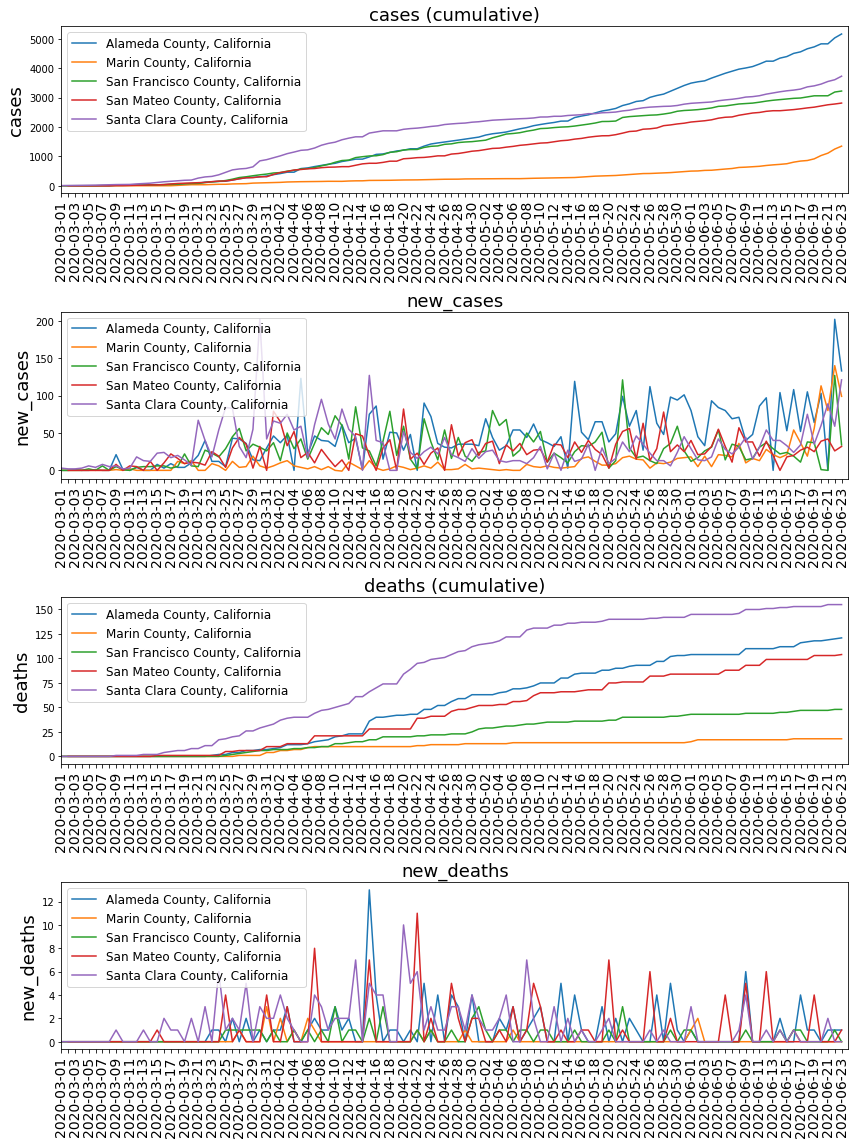

In [11]:
states = ["California"]
counties = [
    "San Francisco County, California",
    "San Mateo County, California",
    "Santa Clara County, California",
    "Alameda County, California",
    "Marin County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-01")

## Some CA, AZ counties

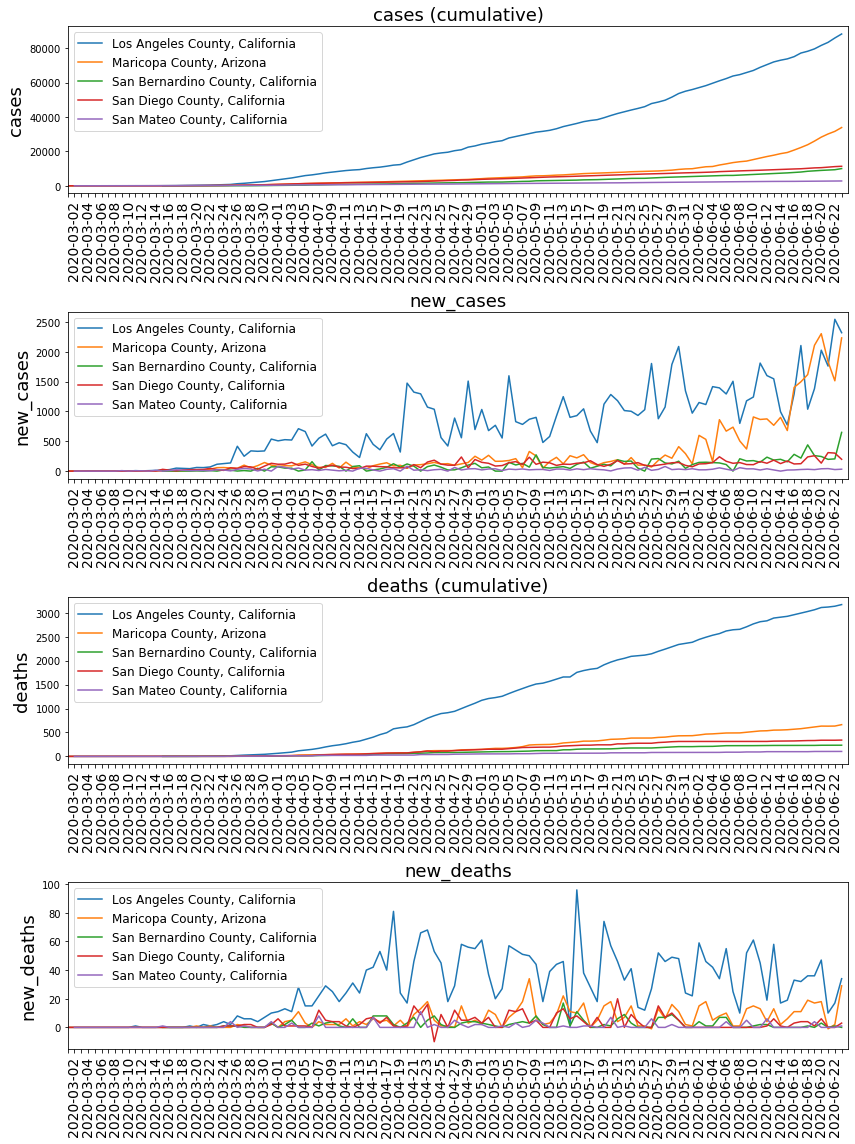

In [12]:
states = ["California", "Arizona"]
counties = [
    "San Bernardino County, California",
    "San Diego County, California",
    "San Mateo County, California",
    "Los Angeles County, California",
    "Maricopa County, Arizona",
]
plot_all_categories_for_county(states, counties, "2020-03-01")

## CA and some East Coast

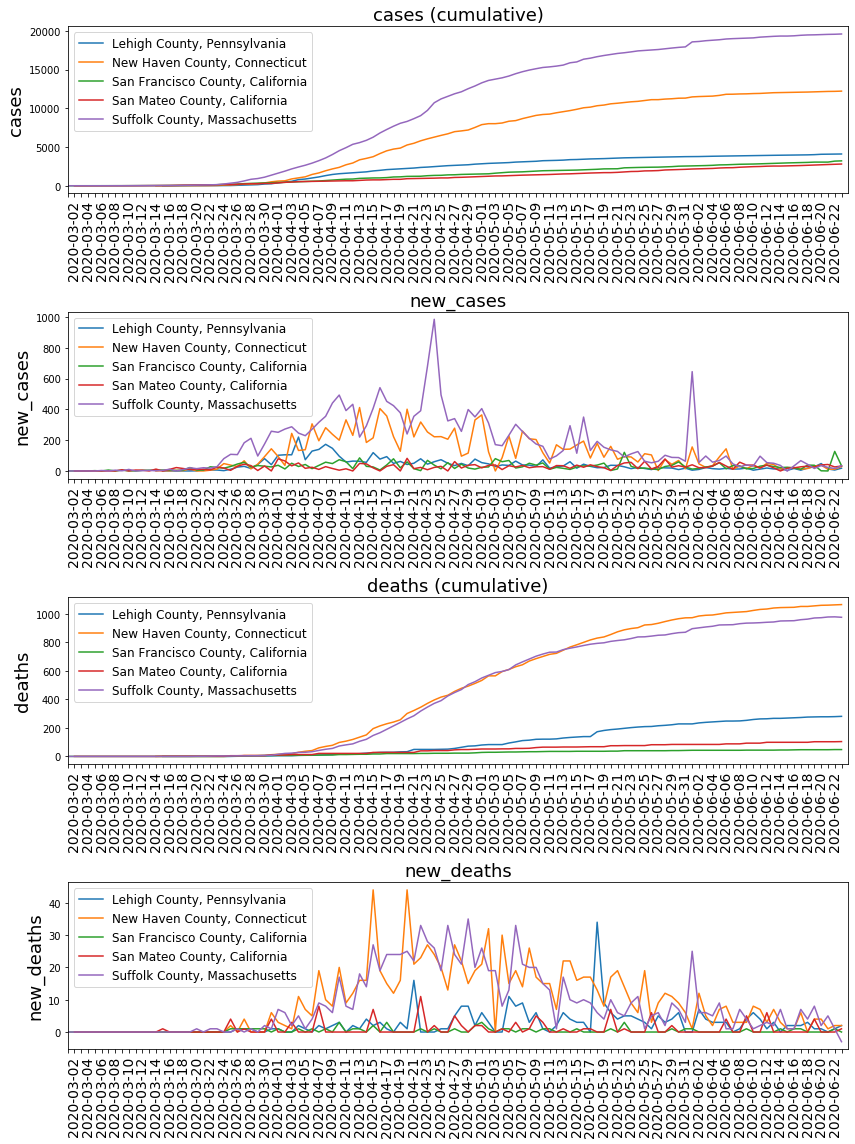

In [13]:
states = ["Pennsylvania", "Connecticut", "California", "Massachusetts"]
counties = [
    "Suffolk County, Massachusetts",
    "New Haven County, Connecticut",
    "Lehigh County, Pennsylvania",
    "San Francisco County, California",
    "San Mateo County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-01")

## New York only

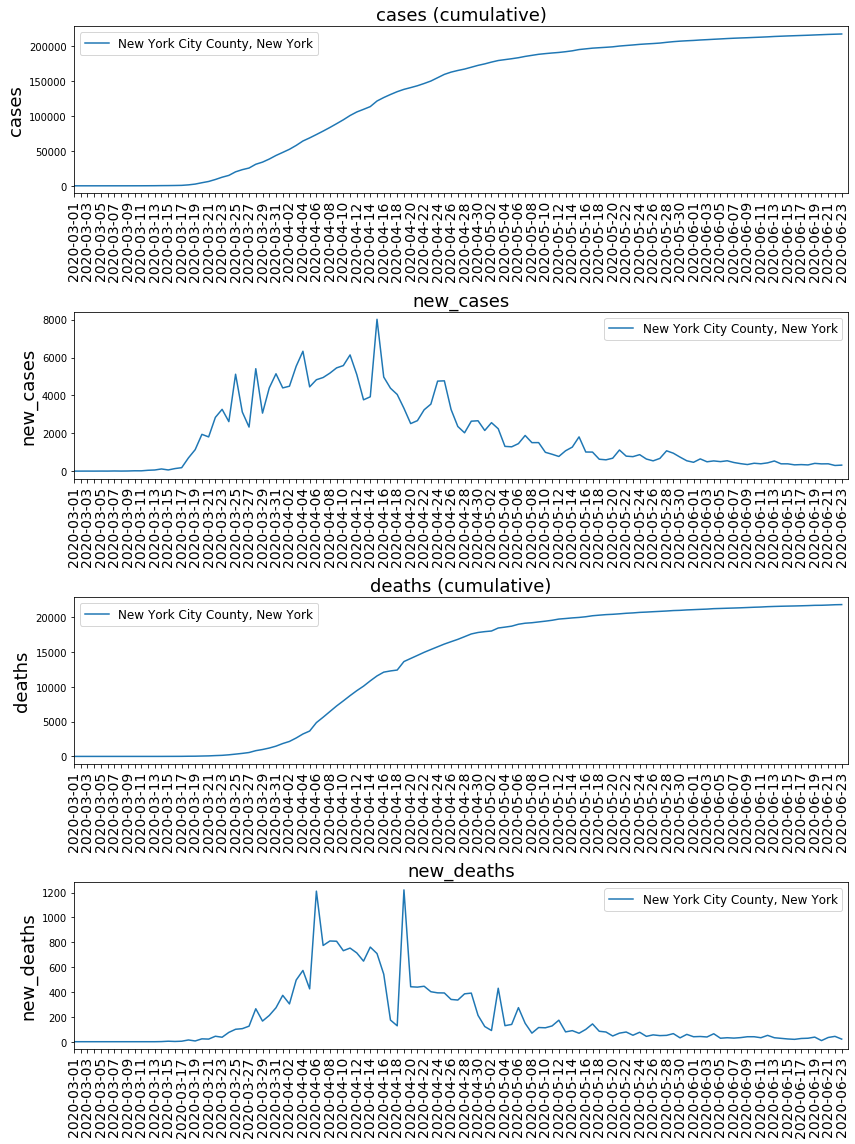

In [14]:
states = ["New York"]
counties = [
    "New York City County, New York",
]
plot_all_categories_for_county(states, counties, "2020-03-01")

## CA, CO, PA, Southeast

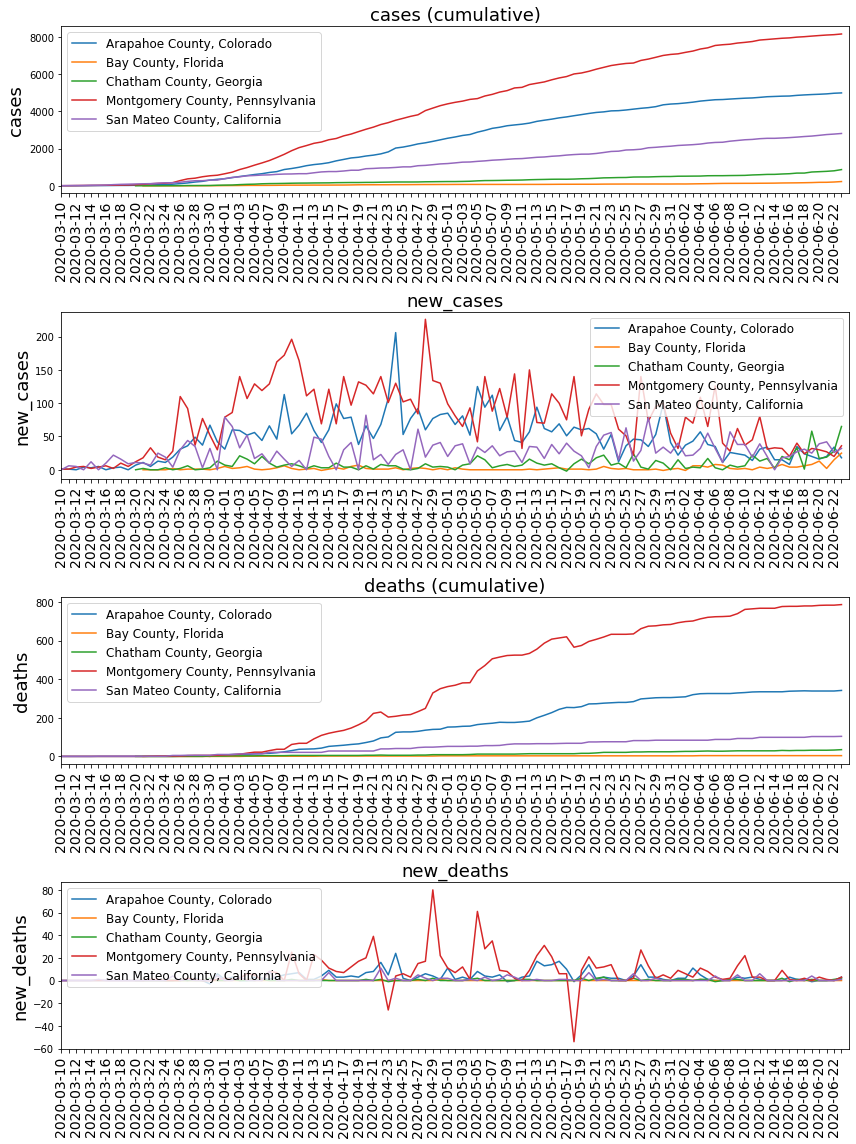

In [15]:
states = ["Colorado", "California", "Pennsylvania", "Georgia", "Florida"]
counties = [
    "Arapahoe County, Colorado",
    "Chatham County, Georgia",
    "Montgomery County, Pennsylvania",
    "Leon Countydd, Florida",
    "Bay County, Florida",
    "San Mateo County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-10")

## CA, WA, Las Vegas

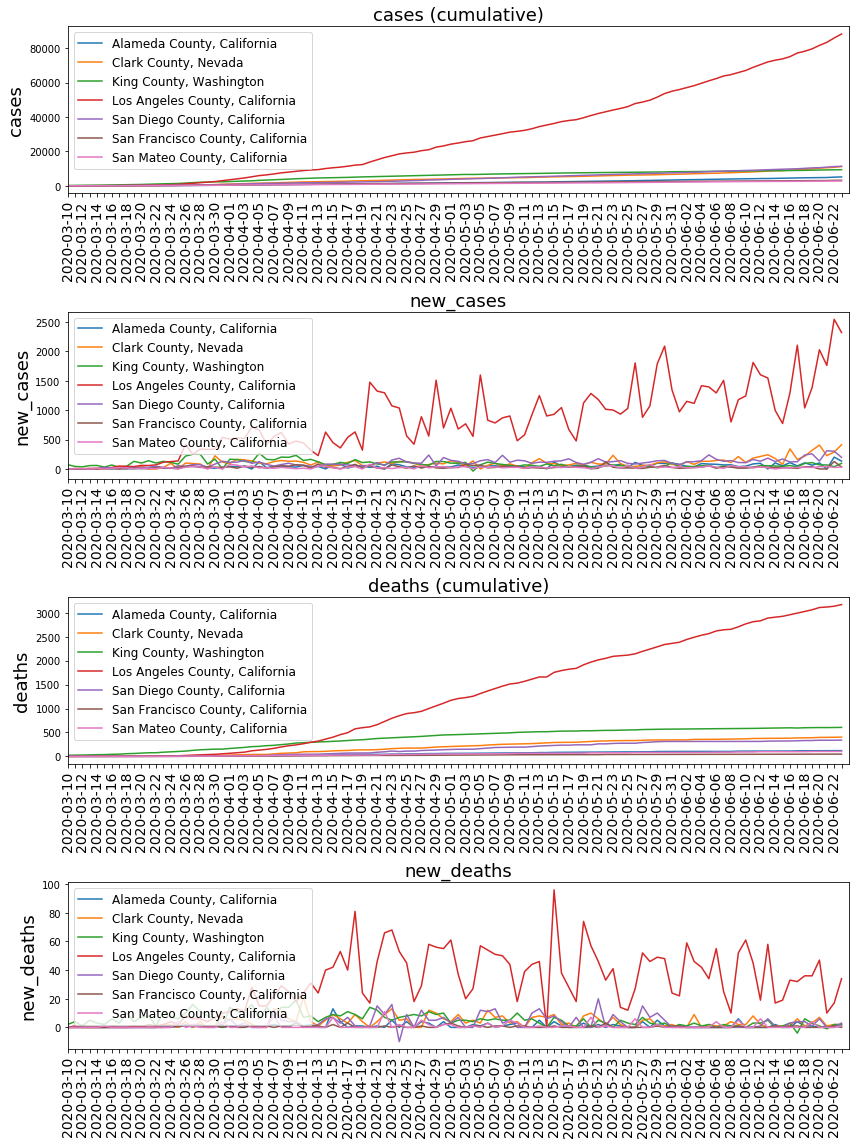

In [16]:
states = ["Nevada", "California", "Washington"]
counties = [
    "Clark County, Nevada",
    "King County, Washington",
    "Los Angeles County, California",
    "San Francisco County, California",
    "San Mateo County, California",
    "Alameda County, California",
    "San Diego County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-10")

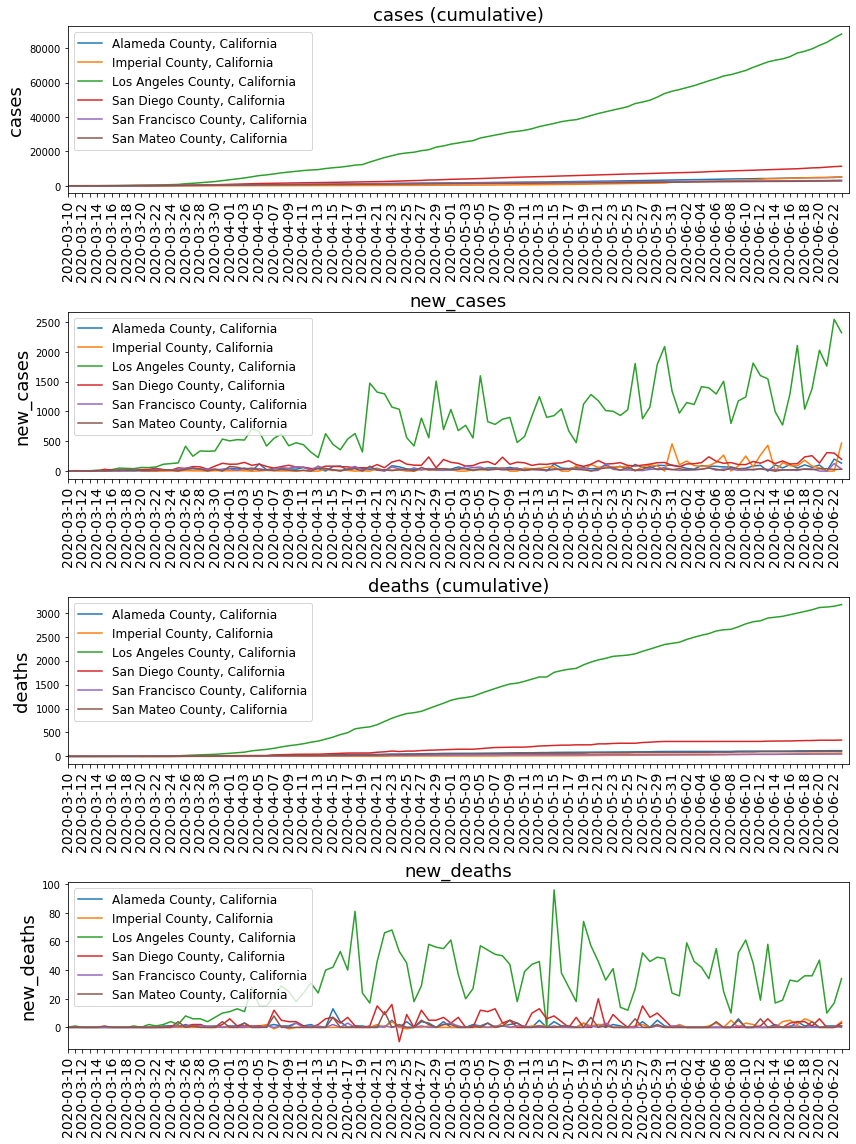

In [17]:
states = ["California"]
counties = [
    "Imperial County, California",
    "Los Angeles County, California",
    "San Francisco County, California",
    "San Mateo County, California",
    "Alameda County, California",
    "San Diego County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-10")

In [18]:
!git commit -a -m "update"
!git push

[master ea6b1a9] update
 1 file changed, 1 insertion(+), 1 deletion(-)
Counting objects: 2, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (2/2), done.
Writing objects: 100% (2/2), 238 bytes | 238.00 KiB/s, done.
Total 2 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/benslack19/covid_cases_by_county.git
   a9ca361..ea6b1a9  master -> master
